# Motorbike Ambulance Calls Regression

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import (cross_val_predict, cross_val_score,
                                     train_test_split, GridSearchCV)
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

from motobike_transformers import FeatureSelector, CategoricalTransformer


data_path = './motorbike_ambulance_calls.csv'
target_col = 'cnt'
rnd_state = 42
cv = 5

In [8]:
# data preparation and pipelines
data = pd.read_csv(data_path, index_col=0)

num_features = [
    'temp',
    'hr',
    'hum'
]
cat_features = [
    'weathersit',
]
cat_values = [
    [1, 2, 3, 4]
]

num_pipeline = Pipeline([
    ('fs', FeatureSelector(features=num_features)),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('fs', FeatureSelector(features=cat_features)),
    ('ct', CategoricalTransformer(categories=cat_values))
])

data_pipeline = FeatureUnion([
    ('num', num_pipeline),
    ('cat', cat_pipeline)
])

## Select the best regressor

In [7]:
y = data[target_col]
X = data.drop(target_col, axis=1)

regressors = [
    ('Ridge', Ridge(random_state=rnd_state)),
    ('Lasso', Lasso(random_state=rnd_state)),
    ('RFR', RandomForestRegressor(n_estimators=100, random_state=rnd_state,
        n_jobs=-1)),
    ('SVR', SVR(gamma='scale'))
]

mae_scores = np.zeros(len(regressors))
pred_cols = [r[0] for r in regressors]
pred_cols.append('y')
predictions = pd.DataFrame(columns=pred_cols, dtype=float, index=X.index)
predictions['y'] = y

for index, (reg_name, reg) in enumerate(regressors):
    reg_pipe = Pipeline([
        ('pipe', data_pipeline),
        (reg_name, reg)
        ])
    
    scores = -1 * cross_val_score(reg_pipe, X, y, cv=cv,
        scoring='neg_mean_absolute_error')
    predictions[reg_name] = cross_val_predict(reg_pipe, X, y, cv=cv, n_jobs=-1)
    
    mae = scores.mean()
    std = scores.std()
    print(f'{reg_name}, MAE = {mae}, std = {std}')

    mae_scores[index] = mae

print(f'The best regressor was {regressors[np.argmin(mae_scores)][0]}')

Ridge, MAE = 116.86799324201561, std = 22.347064953157084
Lasso, MAE = 116.89706457730821, std = 22.50235673704424
RFR, MAE = 87.81417441511584, std = 13.166101704889758
SVR, MAE = 92.57615094644511, std = 27.198774773873893
The best regressor was RFR


## Use grid search

In [11]:
# use Grid search to find the best parameters for Random Forest Regressor
parameters = {
    'RFR__n_estimators': [20, 50, 100, 200],
    'RFR__max_features': ['auto', 'sqrt', 'log2'],
    'RFR__max_depth': [None, 2, 5]
}
reg_pipe = Pipeline([
        ('pipe', data_pipeline),
        ('RFR',  RandomForestRegressor(n_jobs=-1, random_state=rnd_state))
        ])

clf = GridSearchCV(reg_pipe, parameters, cv=cv,
    scoring='neg_mean_absolute_error', n_jobs=-1)
clf.fit(X, y)

print(f'RFR best score {-1 * clf.best_score_}')
print(f'Best parameters {clf.best_params_}')

RFR best score 85.37916626725347
Best parameters {'RFR__max_depth': 5, 'RFR__max_features': 'auto', 'RFR__n_estimators': 50}


In [21]:
best_params = {key[5:]:value for key, value in clf.best_params_.items()}
best_params['random_state'] = rnd_state

reg_best_pipe = Pipeline([
    ('pipe', data_pipeline),
    (reg_name, RandomForestRegressor(**best_params))
    ])

predictions['RFR_best'] = cross_val_predict(reg_best_pipe, X, y, cv=cv, n_jobs=-1)
scores = cross_val_score(reg_best_pipe, X, y, cv=cv, n_jobs=-1, scoring='neg_mean_absolute_error')

print(f'RFR_best MAE = {-1 * scores.mean()}, STD = {scores.std()}')

## Plots

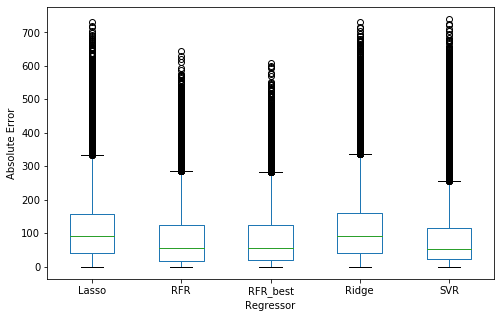

In [58]:
ordered_columns = list(sorted(predictions.drop(['y'], axis=1).columns))

mae = pd.DataFrame(index=predictions.index)

for c in ordered_columns:
    mae[c] = np.abs(predictions[c] - predictions['y'])

mae.plot(kind='box', figsize=(8, 5))
plt.xlabel('Regressor')
plt.ylabel('Absolute Error')
plt.savefig('./mae_regression_boxplot.pdf')
plt.show()

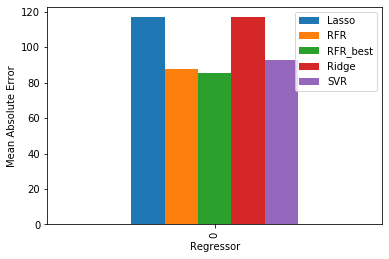

In [60]:
mae = pd.DataFrame(index=[0])

for c in ordered_columns:
    mae[c] = np.mean(np.abs(predictions[c] - predictions['y']))

mae.plot(kind='bar')
plt.xlabel('Regressor')
plt.ylabel('Mean Absolute Error')
plt.savefig('./mae_regression_barplot.pdf')
plt.show()

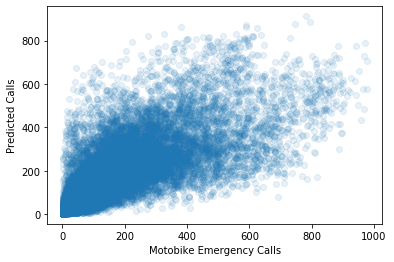

In [61]:
plt.scatter(predictions['y'], predictions['RFR'], alpha=0.1)
plt.xlabel('Motobike Emergency Calls')
plt.ylabel('Predicted Calls')
plt.savefig('./rfr_predicted_vs_actual.pdf')
plt.show()

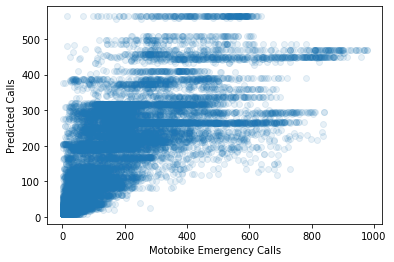

In [62]:
plt.scatter(predictions['y'], predictions['RFR_best'], alpha=0.1)
plt.xlabel('Motobike Emergency Calls')
plt.ylabel('Predicted Calls')
plt.savefig('./rfr_best_predicted_vs_actual.pdf')
plt.show()